# Simulating Gene Distributions with Markov Chain Monte Carlo (MCMC)

The next step is to simulate the distribution of normalized gene counts for each gene. For simplicity, all references to protien coding gene data moving forward will pertain to normalized protien coding gene data unless otherwise specified.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import shapiro, probplot, nbinom, bernoulli
import scipy.stats as stats

import tools as tl

# load data
data1_4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
# normalization
data_norm = tl.RPM(data1_4)


(array([2.06401014e-04, 1.64062345e-04, 3.28124689e-04, 4.71017699e-04,
        6.08618375e-04, 7.67388386e-04, 8.73235060e-04, 9.79081734e-04,
        1.31779109e-03, 1.35483743e-03, 1.42893010e-03, 1.41305310e-03,
        1.48714577e-03, 1.59828478e-03, 1.44480710e-03, 1.27545242e-03,
        1.16960575e-03, 9.84374067e-04, 7.46219051e-04, 7.46219051e-04,
        5.76864373e-04, 3.22832355e-04, 3.22832355e-04, 2.06401014e-04,
        1.58770011e-04, 1.16431341e-04, 1.11139008e-04, 3.17540022e-05,
        3.17540022e-05, 3.70463359e-05, 1.05846674e-05, 1.58770011e-05,
        5.29233369e-06, 1.58770011e-05, 1.05846674e-05, 5.29233369e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.29233369e-06]),
 array([   0.  ,   46.84,   93.68,  140.52,  187.36,  234.2 ,  281.04,
         327.88,  374.7

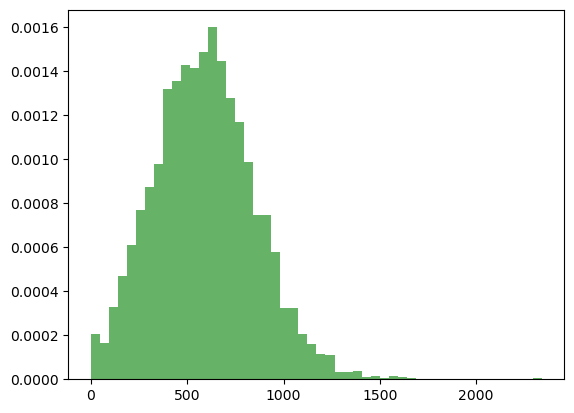

In [2]:
data2_cd4 = pd.read_csv("mt-datasets/Donor2_CD4_Genes.csv")
plt.hist(tl.RPM(data2_cd4)['MT-ATP8'],  bins=50,density=True, alpha=0.6, color='g', label='Real Data Histogram')
# print(tl.TPM(data2_cd4)['MT-ATP8']*4.mean(),np.sqrt(tl.TPM(data2_cd4)['MT-ATP8']*4).var())

## 1. Choose model for the data

### Normal distribution
We'll begin with a normal distribution. To assess how well the data fits this distribution, we can start by plotting a Q-Q plot.

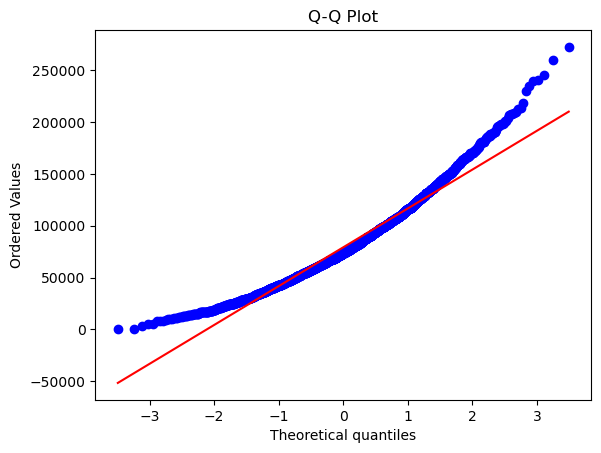

In [63]:
probplot(data_norm['MT-CO1'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

From the Q-Q plot, we observe that the data for MT-CO1 doesn't appear to follow a normal distribution. To further investigate the distribution across all different protien coding gene types, we then apply the Shapiro-Wilk Test.

In [64]:
test = False
for i in data_norm.columns:
    stat, p_value = shapiro(data_norm[i])

    if p_value > 0.05:
        # Fail to reject the null hypothesis - Data follows a normal distribution
        test = True
    else:
        # Reject the null hypothesis - Data does not follow a normal distribution
        continue

if not test:
    print('No data follows a normal distribution')
else:
    print('Exist data that follows a normal distribution')

No data follows a normal distribution


Based on these findings, we can conclude that the normal distribution is not a suitable model for simulating our data.

### Poisson distribution
We then test the fitness of poisson distribution by plotting the scatter plot of the variance and mean of each protien coding gene data.

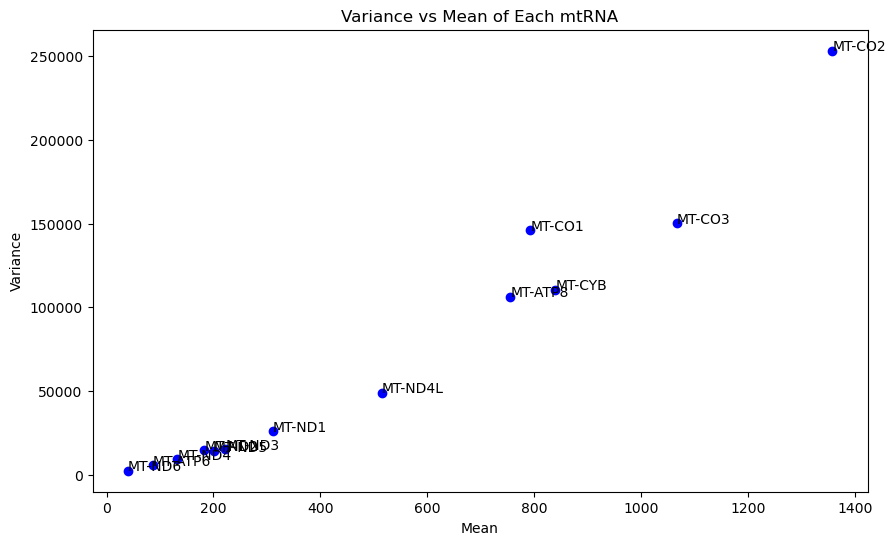

In [3]:
mean_values = data_norm.mean()
var_values = data_norm.var()

plt.figure(figsize=(10, 6))
plt.scatter(mean_values, var_values, color='blue')

# Annotate each point with the gene name
for i, gene in enumerate(data_norm.columns):
    plt.annotate(gene, (mean_values[gene], var_values[gene]))
min_val = min(min(mean_values), min(var_values))
max_val = max(max(mean_values), max(var_values))


# Add titles and labels
plt.title('Variance vs Mean of Each mtRNA')
plt.xlabel('Mean')
plt.ylabel('Variance')

# Show plot
plt.show()

Since we know that in a Poisson distribution, the variance and mean should be equal, we can compare them to check the fit. From the plot, we observe that the scatter points of variance and mean do not align with the red line representing $x = y$. This indicates that the Poisson distribution is also not a suitable model for our data.

### Negative Binomial distribution
After finding that neither the normal nor the Poisson distribution fits our data, we turn to the negative binomial distribution as an alternative model. We plot the distributions for each gene type below. 

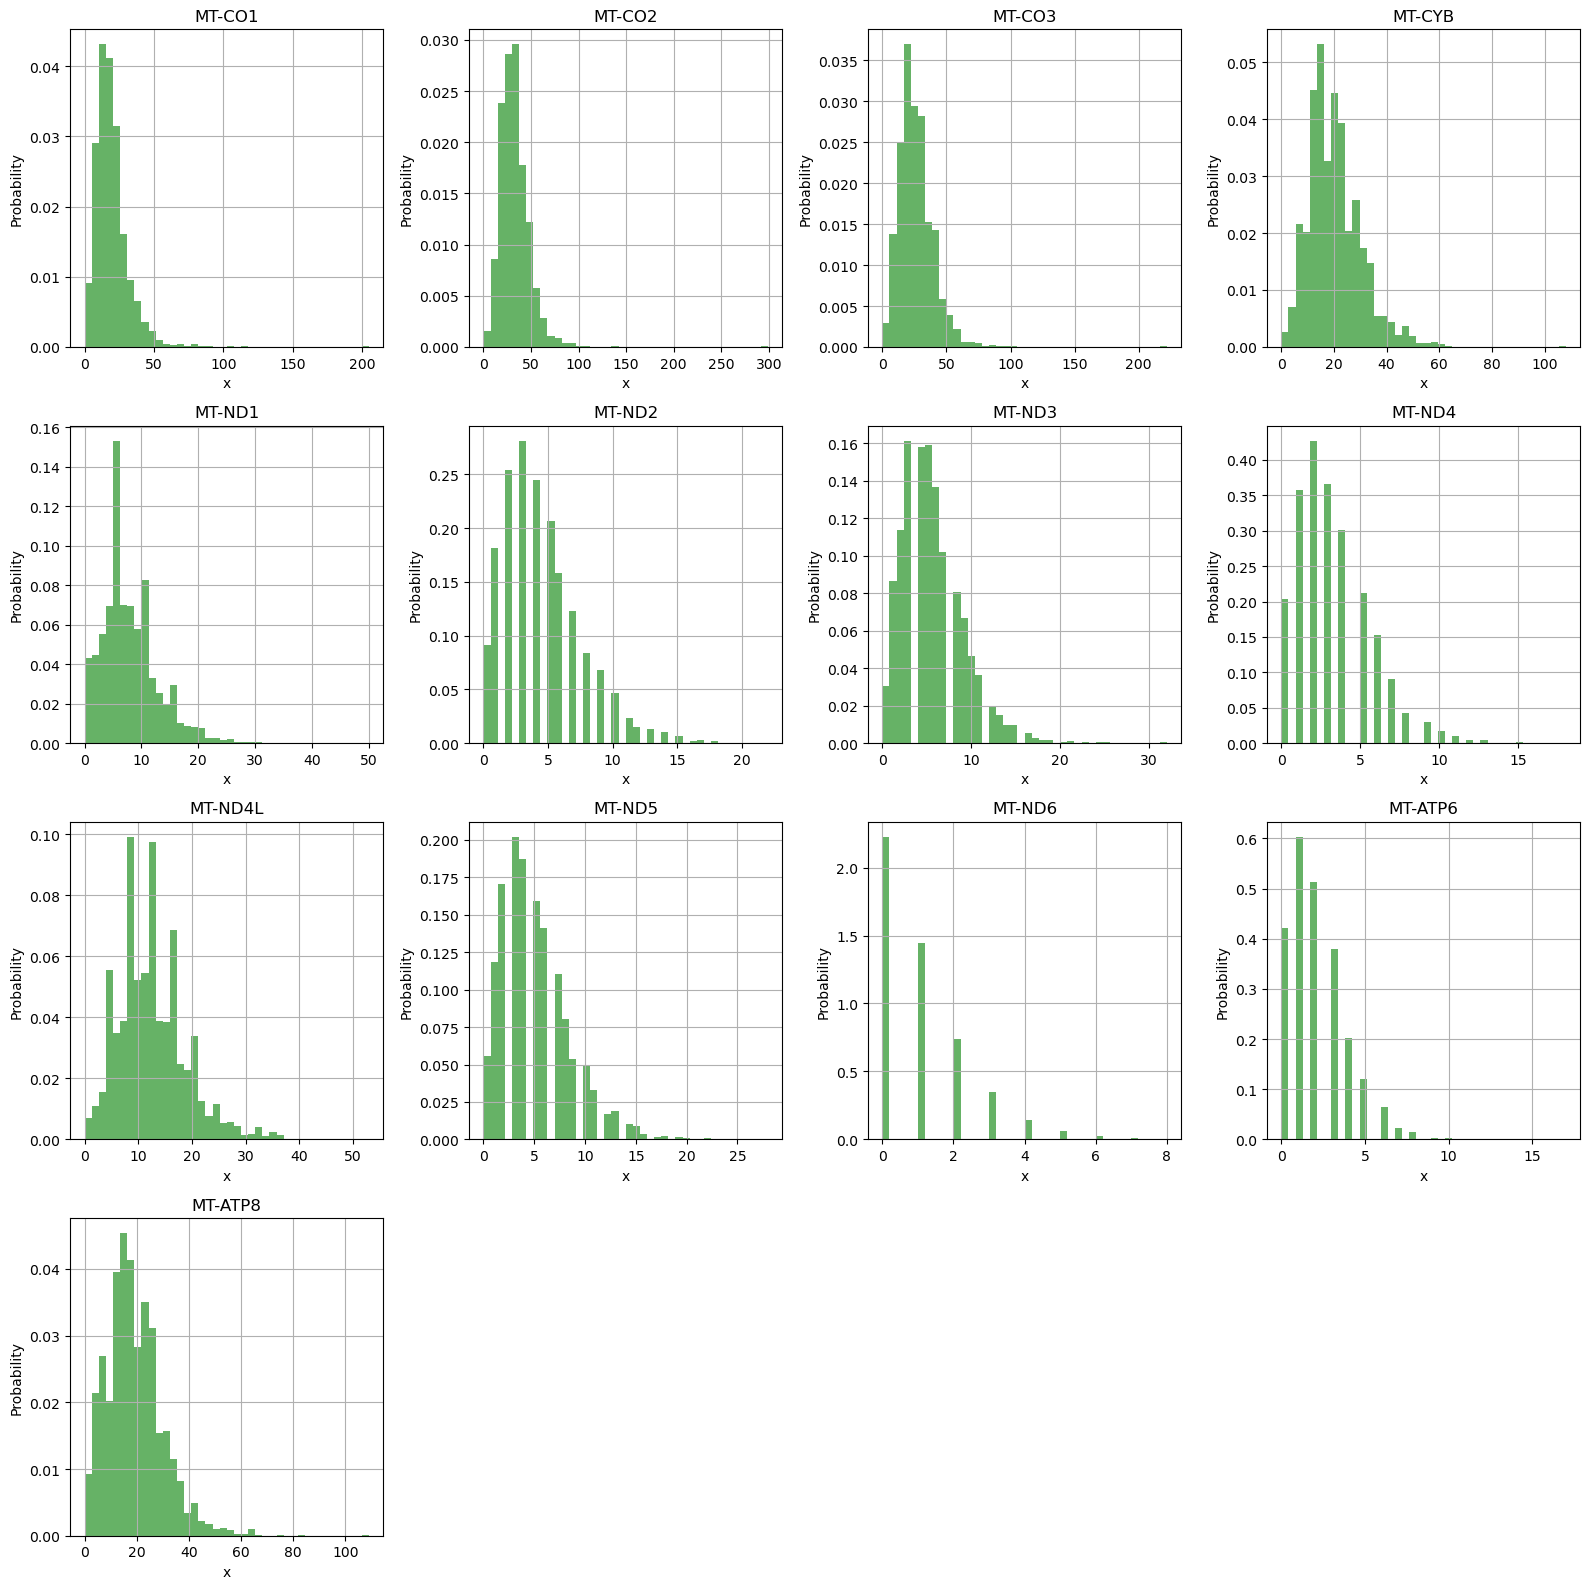

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, key in enumerate(data_norm.columns):
    axes[i].hist(data1_4[key],  bins=40, density=True,
                 alpha=0.6, color='g')

    # Set titles and labels
    axes[i].set_title(f'{key}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Probability')
    axes[i].grid(True)

# Delete the extra graphs
for j in range(13, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [7]:
data_norm

,MT-CO1,MT-CO2,MT-CO3,MT-CYB,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-ATP6,MT-ATP8
0,412563454.0,562447602.0,502087628.0,341792703.0,530621269.0,232720503.0,377026518.0,535618640.0,552715213.0,481795031.0,2.372077e+09,492934604.0,615206456.0
1,430500996.0,371427662.0,449236298.0,290523797.0,353747513.0,310294004.0,188513259.0,749866095.0,414536410.0,412967169.0,3.388682e+08,328623069.0,180943075.0
2,287000664.0,318366567.0,251043814.0,256344527.0,309529074.0,155147002.0,377026518.0,321371184.0,552715213.0,481795031.0,0.000000e+00,164311535.0,144754460.0
3,448438537.0,244081035.0,303895143.0,239254892.0,132655317.0,155147002.0,125675506.0,428494912.0,359264889.0,412967169.0,1.016605e+09,821557673.0,253320305.0
4,107625249.0,275917692.0,145341155.0,119627446.0,265310635.0,232720503.0,251351012.0,0.0,386900649.0,137655723.0,0.000000e+00,164311535.0,253320305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,358750830.0,159183284.0,145341155.0,68358541.0,176873756.0,0.0,125675506.0,214247456.0,138178803.0,206483585.0,0.000000e+00,492934604.0,199037383.0
2884,233188039.0,297142129.0,237830981.0,136717081.0,88436878.0,387867504.0,377026518.0,214247456.0,386900649.0,137655723.0,3.388682e+08,328623069.0,217131690.0
2885,179375415.0,233468816.0,184979652.0,341792703.0,221092195.0,0.0,251351012.0,749866095.0,165814564.0,344139308.0,3.388682e+08,164311535.0,235225998.0
2886,645751493.0,477549851.0,528513292.0,632316500.0,265310635.0,930882011.0,314188765.0,856989823.0,552715213.0,481795031.0,0.000000e+00,328623069.0,343791843.0


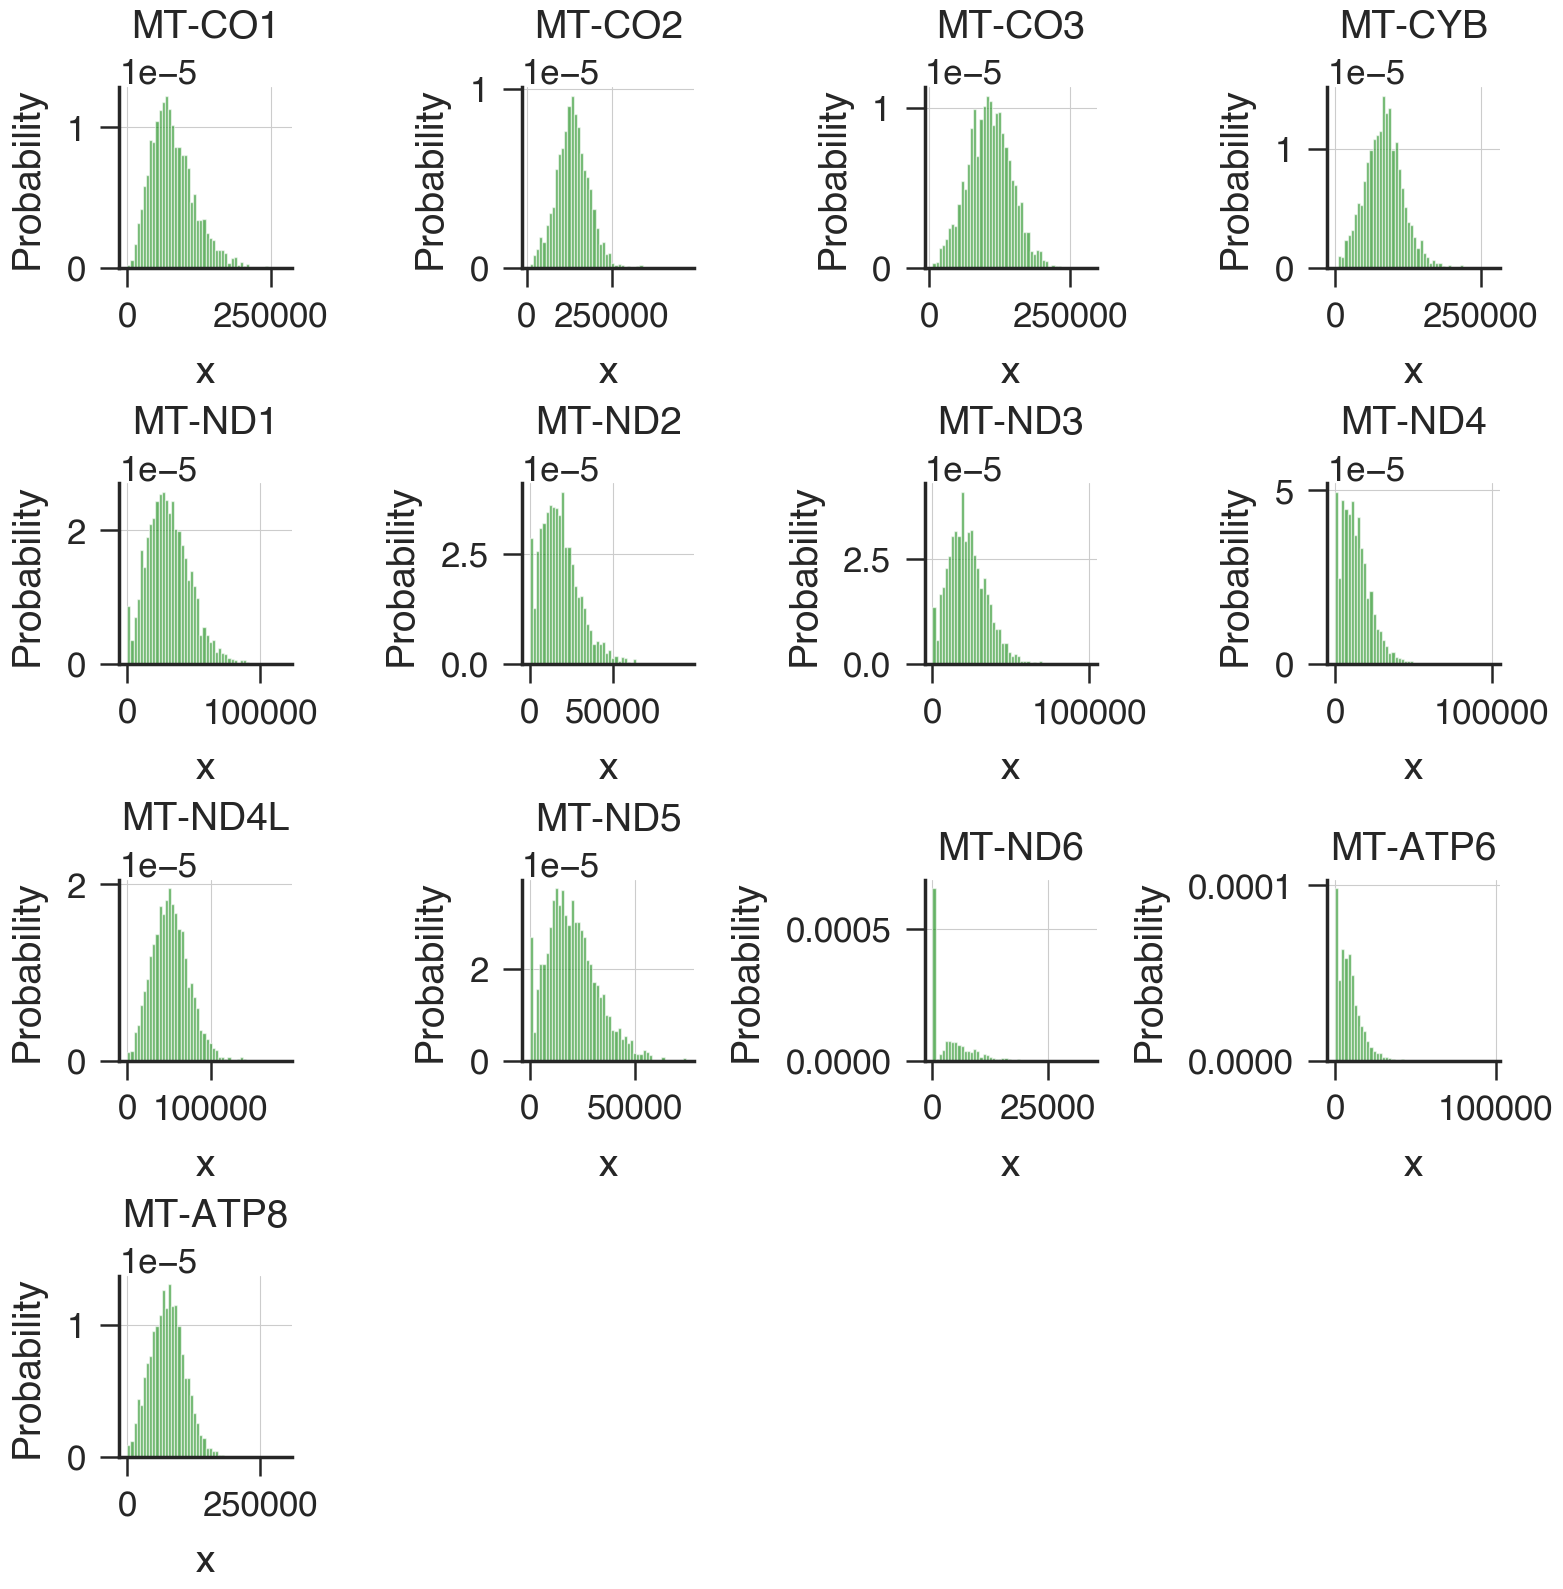

In [119]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, key in enumerate(data_norm.columns):
    axes[i].hist(data_norm[key],  bins=50, density=True,
                 alpha=0.6, color='g')

    # Set titles and labels
    axes[i].set_title(f'{key}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Probability')
    axes[i].grid(True)

# Delete the extra graphs
for j in range(13, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


From the graph above, we observe that the negative binomial distribution may not be the ideal model for handling datasets with a relatively large number of zero counts in certain gene types. To better address this issue, we introduce the zero-inflated negative binomial (ZINB) model, which is more suited for such datasets.

## 2. Metropolis algorithm(symmetric proposal distribution)

We will implement Bayesian inference using the Metropolis algorithm, a type of MCMC method that employs a symmetric proposal distribution. Here we assume our target quantity $y$ follows a distribution with probability function $P(x)$. The steps of this algorithm are outlined below.

- (INITIALIZE)
We begin by choosing an initial value for the hyperparameters, denoted as $\boldsymbol{x}^{(0)}$. This initial value is usually selected randomly or based on some prior knowledge. Additionally, we define the proposal distributions $P_{x_i}$ for each parameter $x_i$. For simplicity, we assume that these proposal distributions are symmetric.

- (PROPOSE)
  - In each iteration $j$, we begin with the current hyperparameter values $\boldsymbol{x}^{(j)}$ and propose new values $\boldsymbol{x}^P$ by sampling from their respective proposal distributions. The parameters of these distributions are set based on the current values of the hyperparameters. 
  - With these newly proposed values, referred to as the 'candidate', we then calculate the acceptance ratio: $$\alpha=\frac{P(\boldsymbol{x}^P)}{P(\boldsymbol{x}^{(j)})}.$$ This ratio compares the likelihood of the candidate parameters against the current parameters.$$ $$

- (ACCEPT OR NOT)
 Finally, we decide wether to accept or reject the the proposed values. We generate a random value $\mu$ from a uniform distribution $\text{Unif}(0,1)$ and compare this value with the acceptance ratio $\alpha$ we calculated previously. 
  - $\mu\le\alpha$ we accept the candidate, and assign the value of $\boldsymbol{x}^P$ to $\boldsymbol{x}^{(j+1)}$.
  - $\mu>\alpha$ we reject the candidate, and retain the current value by assigning $\boldsymbol{x}^{(j)}$ to $\boldsymbol{x}^{(j+1)}$.$$ $$

- (CONTINUE)
We then return to step two and continue generating new values for $\boldsymbol{x}$, repeating the process iteratively to build up a chain of parameter samples.

## 3. Use MCMC to Construct a Negative Binomial Distribution

In this step, we will employ MCMC methods to estimate the parameters and construct a negative binomial distribution for our data. MCMC provides a flexible approach to sampling from complex distributions, where direct analytical solutions may be difficult to obtain.

### 3.1 Model
We first need to decide on the model for performing MCMC. The goal is to estimate the parameters for the normalized gene counts. For each gene $i$, here we assume that the corresponding random variable $Y_i$ follows a Poisson distribution with mean $\mu$ and size $r$. 
$$
Y_i|\mu_i,r_i \sim NB(\mu_i,r_i)
$$
The probability parameter $p$ of the negative binomial distribution can be expressed in terms of $\mu$ and $r$, where:
$p = \frac{r}{\mu+r}.$

In the Metropolis algorithm, we use symmetric proposal distributions. Therefore, we choose the following:
- For $\mu$ we use a normal distribution as the proposal distribution.
$$
\mu^{(j+1)}\sim N(\mu^{(j)}, \sigma_\mu^2)
$$
- For $r$ we use a truncated normal (truncnorm) distribution because $r$ must be positive according to the definition of the negative binomial distribution.
$$
r^{(j+1)}\sim\text{TruncNorm}(r^{(j)},\sigma_r,a =0,b=\infty)
$$
Note that for the truncated normal distribution, the parameters $a$ and $b$ define the range of the distribution, ensuring that proposed values for $r$ are always positive. Additionally, $\sigma_\mu$ and $\sigma_r$ are pre-set parameters that determine the spread of the proposal distributions for $\mu$ and $r$, respectively.

### 3.2 Acceptance ratio
Given that the acceptance ratio $\alpha$ is defined as: $\frac{P(\boldsymbol{x}^P)}{P(\boldsymbol{x}^{(j)})}$ where $P(x)$  is the density function of the negative binomial distribution. For a single observation $x_i$, the probability density function is:
$$
P(x_i|r,\mu) = \frac{\Gamma(x_i+r)}{x_i!\,\Gamma(r)}\left(\frac{r}{r+\mu}\right)^r\left(\frac{\mu}{r+\mu}\right)^{x_i}
$$ 
For $N$ observations, the joint probability density function is:
$$
P(\boldsymbol{x} \mid r, \mu) = \prod_{i=1}^N \frac{\Gamma(x_i + r)}{x_i! \, \Gamma(r)} \left(\frac{r}{r + \mu}\right)^r \left(\frac{\mu}{r + \mu}\right)^{x_i}
$$

Therefore, the acceptance ratio $\alpha$ is:
$$
\alpha = \frac{P(\boldsymbol{x}^P \mid r^P, \mu^P)}{P(\boldsymbol{x}^{(j)} \mid r^{(j)}, \mu^{(j)})}= \prod^N_{i = 1}\frac{P(\boldsymbol{x}^P_i)}{P(\boldsymbol{x}^{(j)}_i)}
$$

Substituting the joint probability density functions, we get:

$$
\alpha = \prod_{i=1}^N\frac{ \frac{\Gamma(x_i + r^P)}{x_i! \, \Gamma(r^P)} \left(\frac{r^P}{r^P + \mu^P}\right)^r \left(\frac{\mu^P}{r^P + \mu^P}\right)^{x_i}}{ \frac{\Gamma(x_i + r^{(j)})}{x_i! \, \Gamma(r^{(j)})} \left(\frac{r^{(j)}}{r^{(j)} + \mu^{(j)}}\right)^r \left(\frac{\mu^{(j)}}{r^{(j)} + \mu^{(j)}}\right)^{x_i}} = \prod_{i=1}^N\frac{ \Gamma(x_i + r^P) \Gamma(r^{(j)}) \left(\frac{r^P}{r^P + \mu^P}\right)^r \left(\frac{\mu^P}{r^P + \mu^P}\right)^{x_i}}{ \Gamma(x_i + r^{(j)}) \Gamma(r^{P}) \left(\frac{r^{(j)}}{r^{(j)} + \mu^{(j)}}\right)^r \left(\frac{\mu^{(j)}}{r^{(j)} + \mu^{(j)}}\right)^{x_i}}
$$

By taking the logarithm of both sides, and do the simplification, we have:

\begin{aligned}
\ln \alpha = \sum_{i=1}^N &\left[ \, \ln \Gamma(x_i + r^P)-\ln\Gamma(x_i + r^{(j)}) + x_i \ln\left( \frac{\mu^P}{r^P + \mu^P} \right)- x_i \log \left( \frac{\mu^{(j)}}{r^{(j)} + \mu^{(j)}} \right)\right]\\
&+N\left[\ln\Gamma(r^{(j)})-\ln\Gamma(r^P)+r^{P}\ln\left(\frac{r^{P}}{r^{P}+\mu^{P}}\right)-r^{(j)}\ln\left(\frac{r^{(j)}}{r^{(j)}+\mu^{(j)}}\right)\right]
\end{aligned}

Here, $N$ is the total number of observations, and $r^P$ and $\mu^P$ are the proposed parameter values in this iteration. This expression will then be used to determine whether to accept or reject the proposed values in the Metropolis algorithm.
The implement of python to calculate this log acceptance ratio is the following:


In [7]:
from scipy.special import gammaln
from scipy.stats import truncnorm
y = data_norm['MT-ATP8']
N = len(y)
x = np.ones(N)

# The function to calculate the acceptance rate
def nb_acceptance_ratio(theta, theta_p, x, N):
    """ theta = (mu, r), x is data, N = len(x) """
    mu, r = theta
    mu_p, r_p = theta_p
    term1 = gammaln(r_p + x)- gammaln(r + x)
    term2 = x * np.log(mu_p / mu * (mu + r)/(mu_p + r_p))
    term3 = N * (gammaln(r) - gammaln(r_p))
    term4 = N *(r_p * np.log(r_p / (r_p + mu_p))-r * np.log(r / (r + mu)))

    return (term1 + term2).sum() + term3 + term4


def truncnorm_prop_pos(x, sigma):  # proposal for r (non-negative)
    return truncnorm.rvs(-x / sigma, np.Inf, loc=x, scale=sigma)

### 3.3 Metropolis Alogrithm

In [114]:
n_iter = 20000
burn_in = 10000
nb_index =  data_norm.columns.to_list()#['MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4L']
nb_data = data_norm[nb_index]


def metropolis_hastings(data, pre_para, n_iter=10000, burn_in=2000, thin=5):
    sigma_mu = pre_para[0]
    sigma_r = pre_para[1]
    trace = np.zeros((n_iter, 2))  # ordered mu, r
    trace[0, :] = np.array([50000., 5.])
    acceptance_rate = np.zeros(n_iter)
    mu = trace[0, 0]

    for i in range(1, n_iter):
        theta = trace[i-1, :]  # theta = (mu, r)

        theta_p = np.array([np.random.normal(theta[0], sigma_mu),
                            truncnorm_prop_pos(theta[1], sigma_r)])
        mu_p = theta_p[0]
        if mu <= 0:
            print("mu == 0 on iteration %d" % i)
        alpha = nb_acceptance_ratio((mu, theta[1]),
                                    (mu_p, theta_p[1]), data, N)
        u = np.log(np.random.uniform(0., 1.))
    
        if u < alpha:
            trace[i, :] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            trace[i, :] = theta
    print("Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin, :])
metropolis_hastings(data_norm['MT-ND1'], [1000,0.05], n_iter=10000, burn_in=2000, thin=5)

Acceptance rate: 0.35


,0,1
0,31316.912290,1.774092
1,31382.086669,1.767850
2,30952.230406,1.792386
3,30952.230406,1.792386
4,30580.786410,1.808523
...,...,...
1595,31294.093922,1.816915
1596,30912.560796,1.836053
1597,30912.560796,1.836053
1598,31326.062355,1.742904


In [115]:
nb_pre_para = pd.DataFrame(np.array([[1000, 1000, 1000, 500, 1000, 1000, 1000, 1000, 1000, 1000, 200, 500, 1500],
                                     [0.3, 0.3, 0.3, 0.5, 0.05, 0.01, 0.01, 0.01, 0.1, 0.01, 0.01, 0.01, 0.1],]), columns=nb_index)

By carefully selecting the values of hyper-parameters, we ensure that the acceptance rate for each gene type falls within a reasonable range, typically between $0.2$ and $0.5$.

In [116]:
nb_paras = pd.DataFrame(np.zeros((2,len(nb_index))),columns=nb_index)
for i, key in enumerate(nb_data.columns):
    vals_mcmc = metropolis_hastings(nb_data[key],nb_pre_para[key],n_iter, burn_in)

    r = vals_mcmc[1].mean()
    mu = vals_mcmc[0].mean()
    p = r/(r+mu)

    nb_paras[key] = np.array([r, p])

Acceptance rate: 0.27
Acceptance rate: 0.42
Acceptance rate: 0.37
Acceptance rate: 0.27
Acceptance rate: 0.36
Acceptance rate: 0.37
Acceptance rate: 0.37
Acceptance rate: 0.33
Acceptance rate: 0.39
Acceptance rate: 0.38
Acceptance rate: 0.27
Acceptance rate: 0.40
Acceptance rate: 0.38


In [158]:
nb_paras

,MT-CO1,MT-CO2,MT-CO3,MT-CYB,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-ATP6,MT-ATP8
0,3.907417,6.465204,6.280967,5.218591,1.761957,0.881218,1.488406,0.557830,3.902044,1.090023,0.100475,0.307092,3.433520
1,0.000049,0.000048,0.000059,0.000062,0.000057,0.000048,0.000067,0.000042,0.000076,0.000054,0.000025,0.000036,0.000045


### 3.3 Visulization
We then plot the graphs for each gene type to visualize how well the model fits the data.

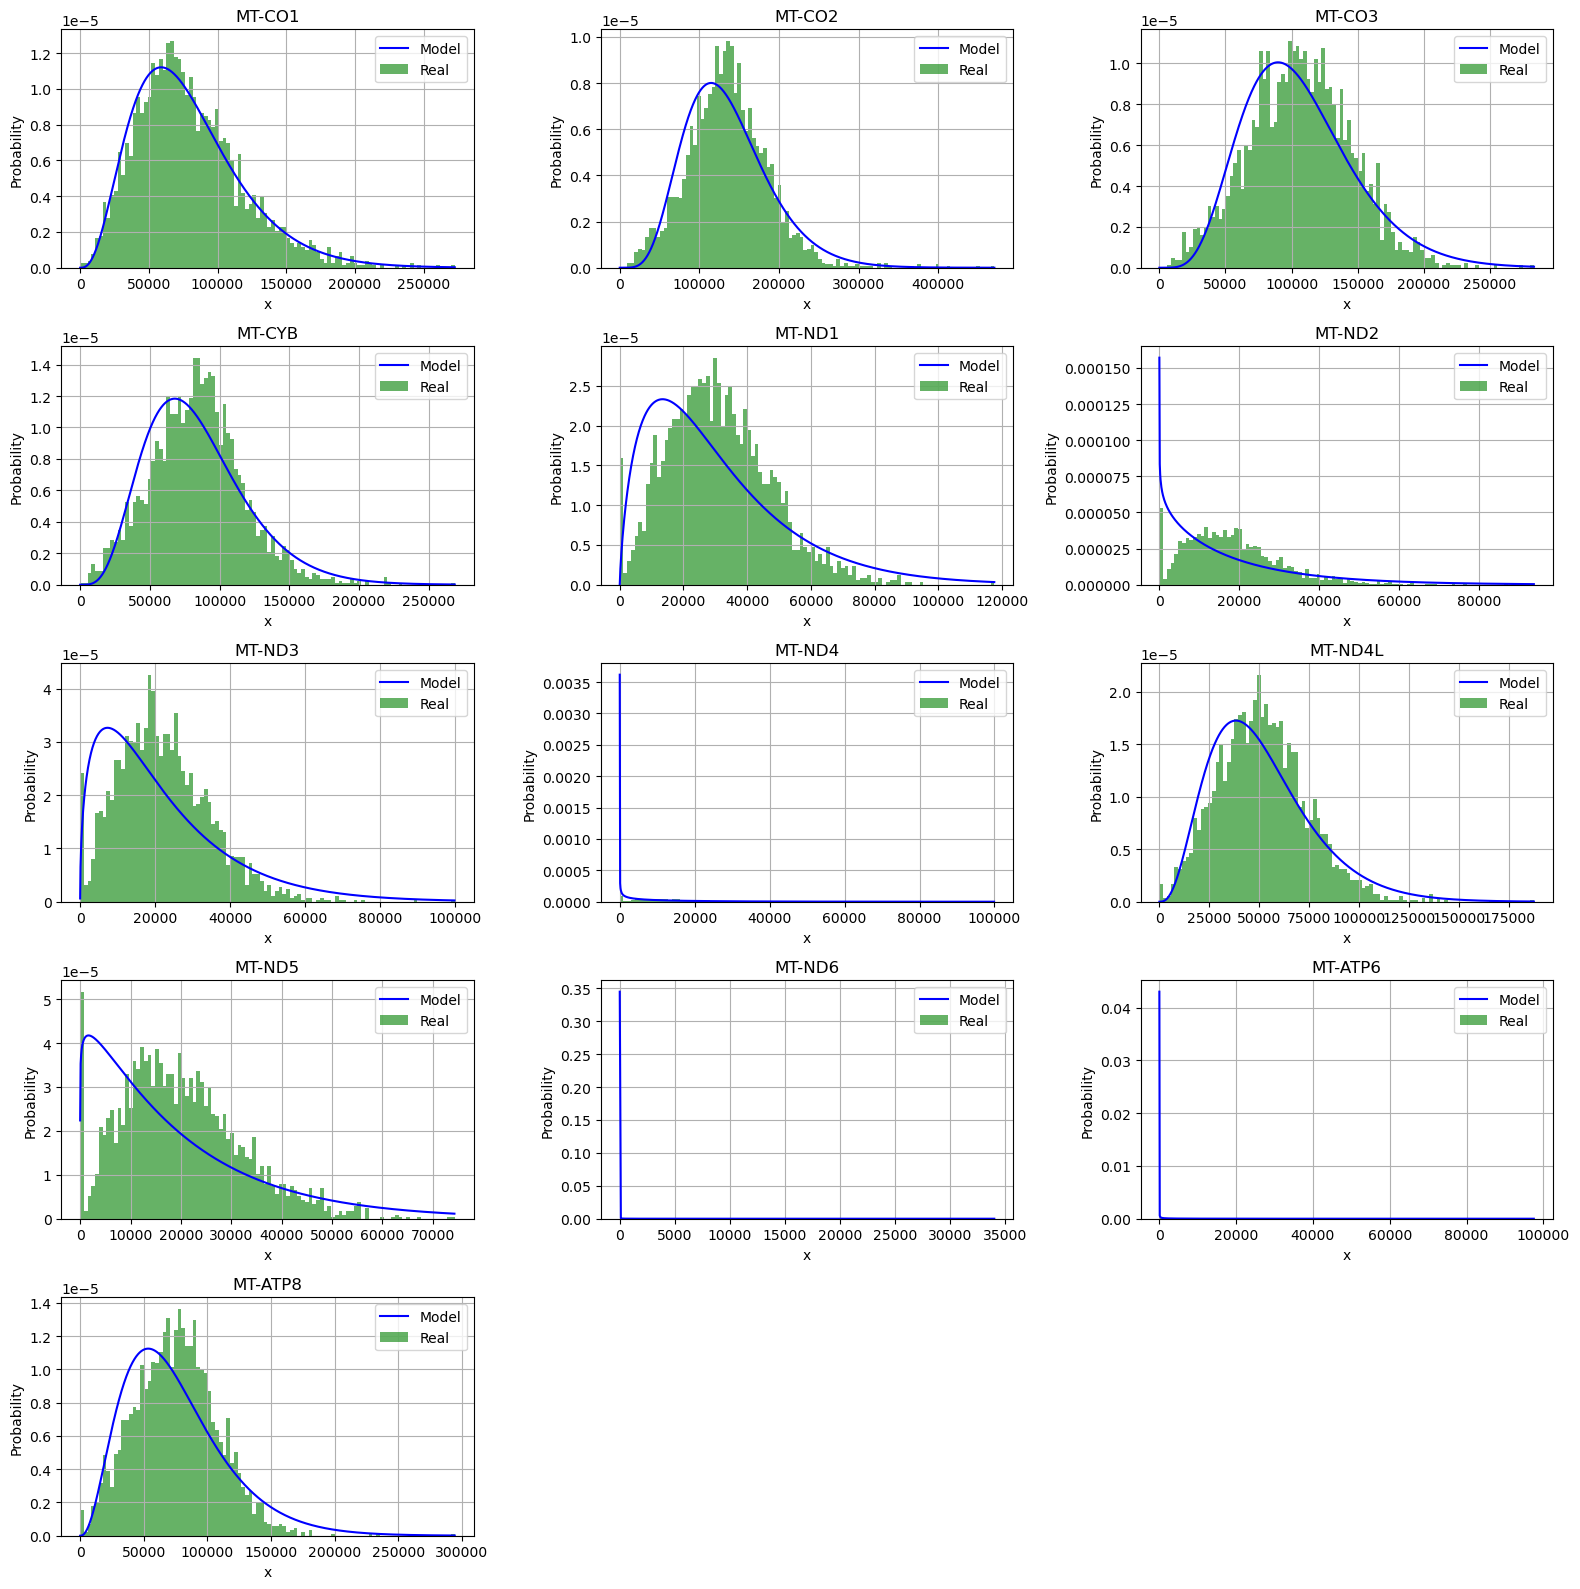

In [167]:

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))
axes = axes.flatten()  
for i, key in enumerate(nb_data.columns):
    x = np.array(range(0, int(data_norm[key].max()),100))
    # Compute the Negative Binomial distribution PDF values

    pmf = [stats.nbinom.pmf(j, n=nb_paras[key][0], p=nb_paras[key][1]) for j in x]

    # Plot the Negative Binomial distribution
    axes[i].plot(x, pmf, color='b', label='Model')
    axes[i].hist(data_norm[key],  bins=100, density=True,
                 alpha=0.6, color='g', label='Real')

    # Set titles and labels
    axes[i].set_title(f'{key}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Probability')
    axes[i].legend()
    axes[i].grid(True)

# Delete the extra graphs
for j in range(13, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 4. ZINB Model

Similarly, we use MCMC to simulate data with a large number of zero counts, but this time we set the target distribution to be ZINB. The ZINB distribution can be thought of as a Bernoulli distribution applied to a negative binomial distribution. Its probability mass function (PMF) is given by:
$$
P(X = x) =
\begin{cases} 
(1-\psi) + \psi  \left(\frac{r}{r+\mu}\right)^r & \text{if } x = 0, \\
\psi \frac{\Gamma(x + r)}{x! \, \Gamma(r)}  \left(\frac{r}{r+\mu}\right)^r\left(\frac{\mu}{r+\mu}\right)^{x_i} & \text{if } x  > 0.
\end{cases}
$$
Here is a Python implementation of the PMF for the ZINB distribution:

In [22]:
def zinb_pmf(x, paras):
    """
    Calculate the PMF of the ZINB distribution.
    
    Returns:
        float: The probability of observing count x.
    """
    # Negative Binomial distribution parameters
    mu, r, psi = paras
    p = r / (r + mu)  
    
    # If k is 0, the probability includes both zero-inflation and NB zero-probability
    if x == 0:
        return 1-psi + psi * nbinom.pmf(0, r, p)
    else:
        # For k > 0, it's just the NB probability scaled by (1 - pi)
        return  psi * nbinom.pmf(x, r, p)


Since the ZINB distribution includes an additional parameter $\psi $, which ranges between 0 and 1, we use a truncated normal distribution for its proposal distribution to ensure that the sampled values remain within the proper range. For the acceptance ratio $\alpha $, it is calculated based on the PMF defined earlier, and we get the value of the log acceptance ratio as follows:
\begin{aligned}
\ln \alpha = \sum_{x_i\neq0} &\left[ \, \ln \Gamma(x_i + r^P)-\ln\Gamma(x_i + r^{(j)}) + x_i \ln\left( \frac{\mu^P}{r^P + \mu^P} \right)- x_i \log \left( \frac{\mu^{(j)}}{r^{(j)} + \mu^{(j)}} \right)\right]\\
&+N_1\left[\ln\Gamma(r^{(j)})-\ln\Gamma(r^P)+r^{P}\ln\left(\frac{r^{P}}{r^{P}+\mu^{P}}\right)-r^{(j)}\ln\left(\frac{r^{(j)}}{r^{(j)}+\mu^{(j)}}\right)\right]\\
&+N_0\left[ln\left((1-\psi^P)+\psi^P\left(\frac{r^{P}}{r^{P}+\mu^{P}}\right)^{r^P}\right)-ln\left((1-\psi^{(j)})-\psi^{(j)}\left(\frac{r^{{(j)}}}{r^{{(j)}}+\mu^{{(j)}}}\right)^{r^{(j)}}\right)\right]
\end{aligned}
Here, $N_1$ represents the number of counts that are not zero, and $N_0$ denotes the number of zero counts.

In [106]:
zinb_index = ['MT-CO1','MT-CYB','MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4','MT-ND4L', 'MT-ND5', 'MT-ND6', 'MT-ATP6', 'MT-ATP8']

zinb_data = data_norm[zinb_index]


def zinb_acceptance_ratio(theta, theta_p, data):
    """
    Calculate the log acceptance ratio for the Metropolis algorithm.

    Parameters:
    - theta: Current parameter values
    - theta_p: proposed parameter values
    - x: Array of observations

    Return:
    - log acceptance ratio
    """
    y_0 = data[data == 0]
    y_1 = data[data != 0]
    N_0 = len(y_0)
    N_1 = len(y_1)

    mu, r, psi = theta
    mu_p, r_p, psi_p = theta_p
    term1 = gammaln(r_p + y_1) - gammaln(r + y_1)
    term2 = y_1 * np.log(mu_p / mu * (mu + r)/(mu_p + r_p))
    term3 = N_1 * (gammaln(r) - gammaln(r_p)+np.log(psi_p)-np.log(psi))
    term4 = N_1 * (r_p * np.log(r_p / (r_p + mu_p))-r * np.log(r / (r + mu)))

    term5 = -np.log((1-psi)+psi*pow(r/(r+mu), r)) + \
        np.log((1-psi_p)+psi_p*pow(r_p/(r_p+mu_p), r_p))
    return (term1 + term2).sum() + term3 + term4 + term5 * N_0


def truncnorm_prop_psi(x, sigma):  # proposal for psi (non-negative)
    return truncnorm.rvs(-x / sigma, (1-x) / sigma, loc=x, scale=sigma)

norm

In [104]:
zinb_pre_para_d = {'MT-CO1': [1000, 0.3, 0.0003],
                 'MT-CYB': [1000, 0.3, 0.0003],
                 'MT-ND1': [500,0.07,0.005],
                 'MT-ND2': [500,0.07,0.005],
                 'MT-ND3': [500,0.07,0.005],
                 'MT-ND4': [500,0.07,0.005],
                 'MT-ND4L' : [500,0.07,0.005],
                 'MT-ND5':[500,0.07,0.005],
                 'MT-ND6':[200,0.07,0.005],
                 'MT-ATP6':[500,0.07,0.003],
                 'MT-ATP8':[500,0.07,0.005]
                 }


zinb_pre_para = pd.DataFrame(zinb_pre_para_d)

In [110]:
name_1 = 'MT-ATP6'
para = [500,0.07,0.003]

In [111]:
def metropolis_hastings_zinb(data,pre_para,n_iter=10000, burn_in=2000, thin=5):
    sigma_mu = pre_para[0]
    sigma_r = pre_para[1]
    sigma_psi = pre_para[2]
    trace = np.zeros((n_iter, 3))  # ordered mu, r, psi
    trace[0, :] = np.array([5000., 5.,0.9])
    acceptance_rate = np.zeros(n_iter)
    mu = trace[0, 0]

    for i in range(1, n_iter):
        theta = trace[i-1, :]  # theta = (mu, r, psi)

        theta_p = np.array([np.random.normal(theta[0], sigma_mu),
                            truncnorm_prop_pos(theta[1], sigma_r),
                            truncnorm_prop_psi(theta[2], sigma_psi)])
        mu_p = theta_p[0]
        if mu <= 0:
            print("mu == 0 on iteration %d" % i)

        alpha = zinb_acceptance_ratio((mu, theta[1],theta[2]),
                                    (mu_p, theta_p[1],theta_p[2]), data)
        u = np.log(np.random.uniform(0., 1.))

        if u < alpha:
            trace[i, :] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            trace[i, :] = theta
    print( "Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin, :])
trace = metropolis_hastings_zinb(zinb_data[name_1],para,n_iter=10000, burn_in=5000)
print(trace.mean())

Acceptance rate: 0.25
0    10481.595218
1        2.609567
2        0.821857
dtype: float64


In [15]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False
}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

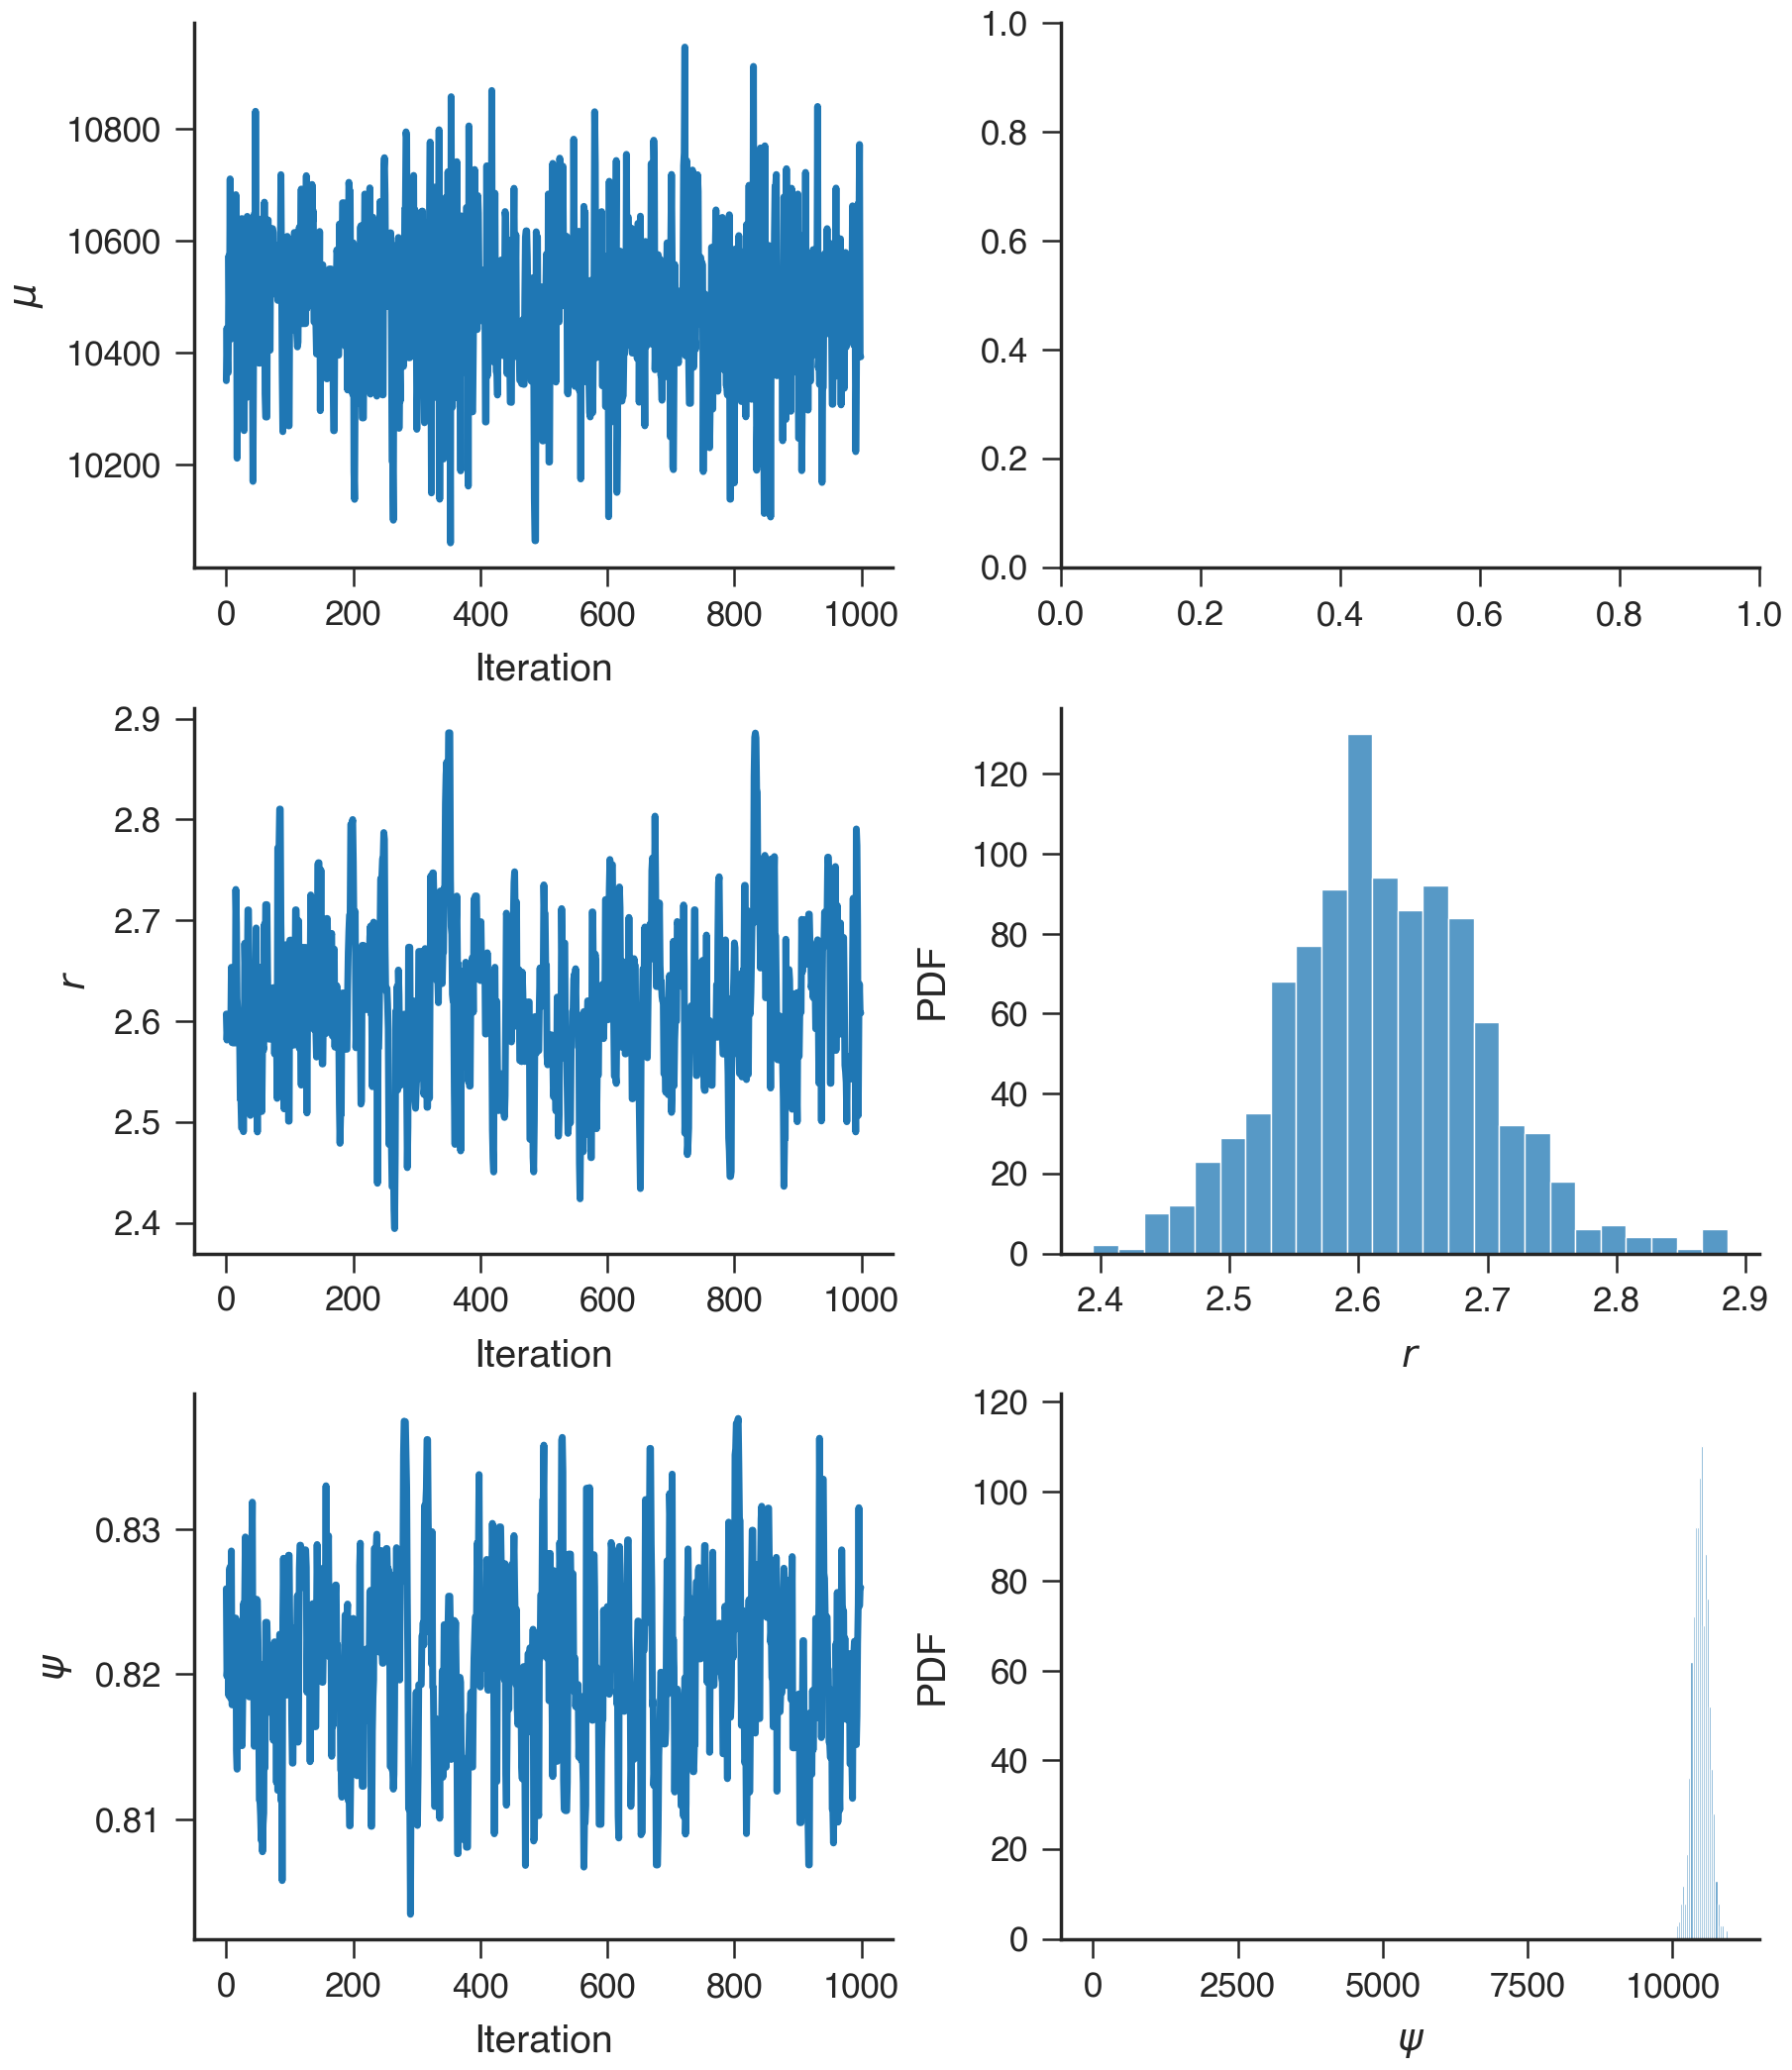

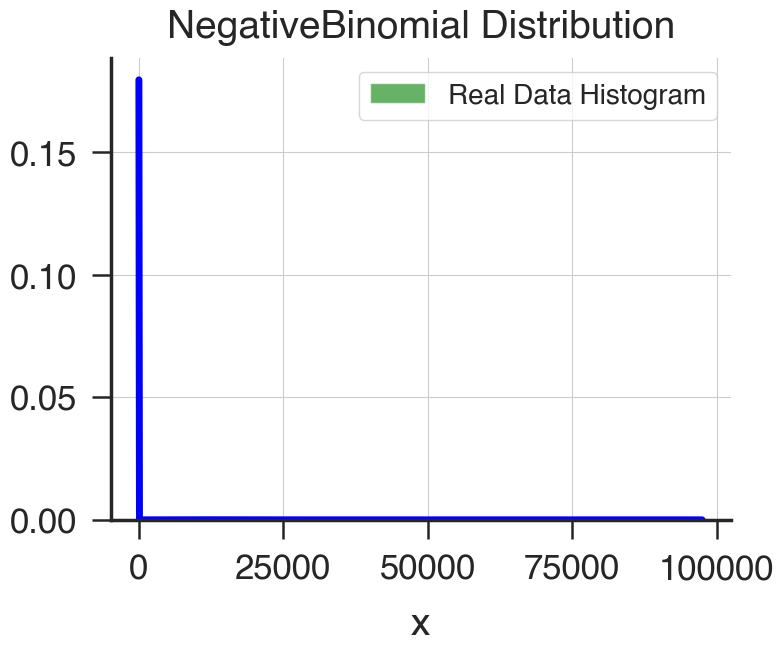

In [102]:
trace=pd.DataFrame(trace[:])
f, axs = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
p = 1 - trace[0] / (trace[1] + trace[0])
labels=[r'$\mu$',r'$r$',r'$\psi$']
count=0
ax=axs.flatten()[0]
ax.plot(trace[0])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[0])

ax=axs.flatten()
sns.histplot(trace[0])


ax=axs.flatten()[2]
ax.plot(trace[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[1])

ax=axs.flatten()[3]
sns.histplot(trace[1],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[1])
f.tight_layout()

ax=axs.flatten()[4]
ax.plot(trace[2])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[2])

ax=axs.flatten()[5]
sns.histplot(trace[2],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[2])
f.tight_layout()

col_means=trace.mean()
#col_means[0] = trace[0].mean()
#col_means[1] = trace.mean()
# Compute the Gamma distribution PDF values
# x = np.array(range(0,round(data1_cd4[name_0].max())))
x = np.array(range(0,int(zinb_data[name_1].max()),100))
pmf = [zinb_pmf(i, col_means) for i in x]
#pmf = [stats.nbinom.pmf(i, n=9.335, p=0.036) for i in x]

# Plot the Gamma distribution
plt.figure(figsize=(8, 6))
plt.plot(x, pmf,  color='b')

plt.hist(zinb_data[name_1],  bins=50,density=True, alpha=0.6, color='g', label='Real Data Histogram')

plt.title('NegativeBinomial Distribution')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()

(array([6.54287526e-04, 7.63759758e-06, 2.39311391e-05, 4.02246806e-05,
        7.58668027e-05, 7.48484563e-05, 7.07750709e-05, 7.17934173e-05,
        5.95732611e-05, 5.39723563e-05, 3.61512952e-05, 3.51329489e-05,
        3.25870830e-05, 4.22613733e-05, 3.51329489e-05, 1.52751952e-05,
        2.49494854e-05, 2.29127927e-05, 1.22201561e-05, 9.67429027e-06,
        5.60090489e-06, 7.63759758e-06, 1.06926366e-05, 8.65594393e-06,
        6.11007807e-06, 3.05503903e-06, 3.56421221e-06, 4.58255855e-06,
        4.07338538e-06, 3.05503903e-06, 2.03669269e-06, 2.03669269e-06,
        1.01834634e-06, 5.09173172e-07, 2.03669269e-06, 5.09173172e-07,
        1.01834634e-06, 5.09173172e-07, 5.09173172e-07, 5.09173172e-07,
        1.01834634e-06, 5.09173172e-07, 5.09173172e-07, 0.00000000e+00,
        5.09173172e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.09173172e-07]),
 array([    0.  ,   680.28,  1360.56,  2040.84,  2721.12,  3401.4 ,
         4081.68,  4761.96

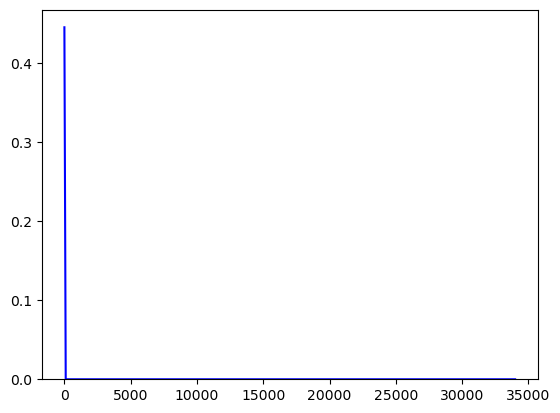

In [172]:
x = np.array(range(0, round(data_norm[name_1].max()),100))
# Compute the ZINB distribution PDF values
pmf = [zinb_pmf(j, res) for j in x]

# Plot the Negative Binomial distribution
plt.plot(x, pmf, color='b', label='ZINB Model')
plt.hist(data_norm[name_1],  bins=50, density=True,
                alpha=0.6, color='g', label='Real Data')

In [107]:
n_iter = 10000
burn_in = 5000
zinb_paras = pd.DataFrame(np.zeros((3,len(zinb_index))),columns=zinb_index) ###

for i, key in enumerate(zinb_data.columns):
    vals_mcmc = metropolis_hastings_zinb(zinb_data[key],zinb_pre_para[key],n_iter, burn_in)

    zinb_paras[key] = vals_mcmc.mean()
print(zinb_paras)

Acceptance rate: 0.26
Acceptance rate: 0.31
Acceptance rate: 0.29
Acceptance rate: 0.29
Acceptance rate: 0.27
Acceptance rate: 0.26
Acceptance rate: 0.26
Acceptance rate: 0.29
Acceptance rate: 0.43
Acceptance rate: 0.22
Acceptance rate: 0.27
         MT-CO1        MT-CYB        MT-ND1        MT-ND2        MT-ND3  \
0  79329.375901  83951.149237  31685.895302  19220.621410  22809.604199   
1      4.090322      5.363383      3.602833      2.728260      3.332076   
2      0.998939      0.999199      0.981357      0.949771      0.975213   

         MT-ND4       MT-ND4L        MT-ND5       MT-ND6       MT-ATP6  \
0  14608.657163  51649.091062  20899.709105  7156.192152  10469.159732   
1      2.615771      4.813053      3.065370     2.927348      2.607708   
2      0.908243      0.996413      0.961482     0.555612      0.821860   

        MT-ATP8  
0  75964.806966  
1      4.633316  
2      0.995032  


IndexError: index 10 is out of bounds for axis 0 with size 10

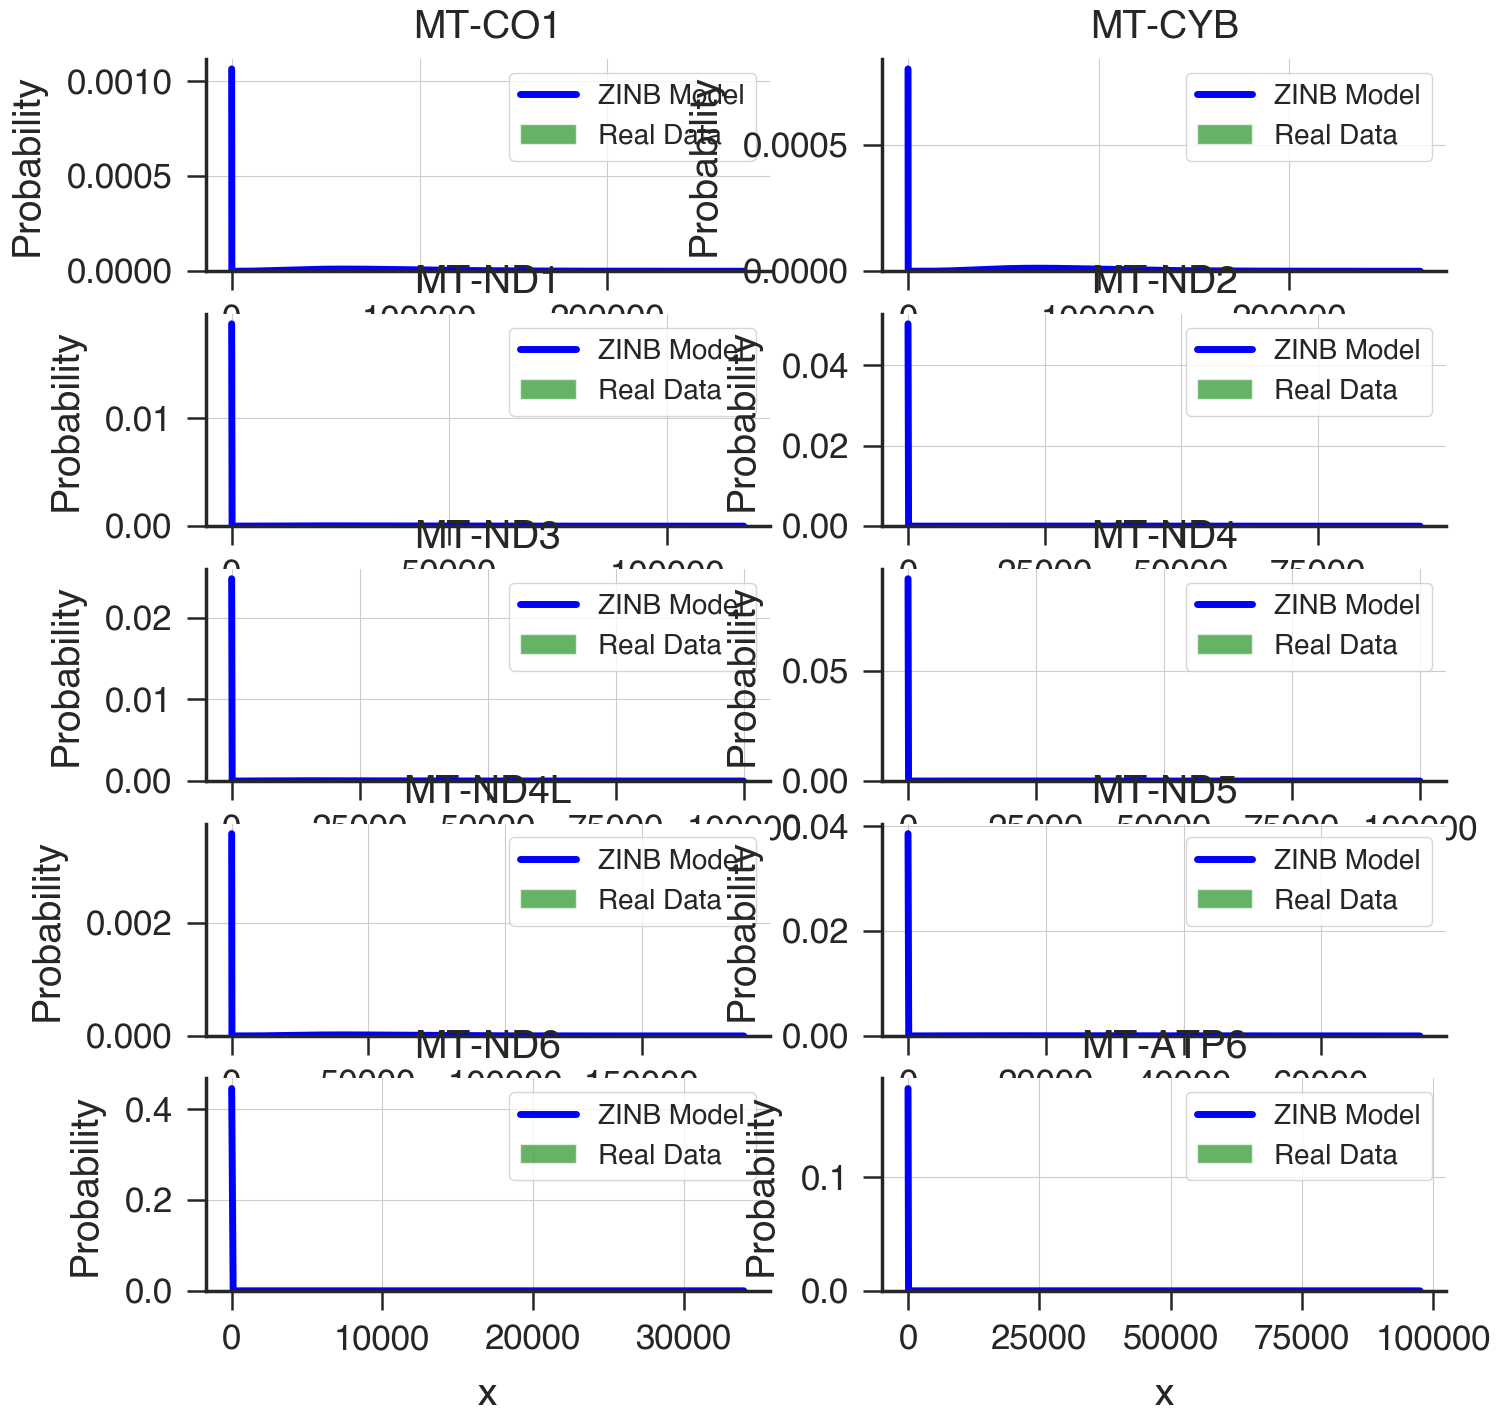

In [112]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, key in enumerate(zinb_data.columns):
    x = np.array(range(0, round(data_norm[key].max()),100))
    # Compute the ZINB distribution PDF values
    pmf = [zinb_pmf(j, zinb_paras[key]) for j in x]

    # Plot the Negative Binomial distribution
    axes[i].plot(x, pmf, color='b', label='ZINB Model')
    axes[i].hist(data_norm[key],  bins=100, density=True,
                 alpha=0.6, color='g', label='Real Data')

    # Set titles and labels
    #axes[i].set_ylim([0, 0.002])
    axes[i].set_title(f'{key}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Probability')
    axes[i].legend()
    axes[i].grid(True)

# Delete the extra graphs
for j in range(len(zinb_index), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [9]:
zero_ratio = {}
for i, key in enumerate(data_norm.columns):
    zero_ratio[key]=len(data_norm[key][data_norm[key]==0])/len(data_norm[key])
zero_ratio

{'MT-CO1': 0.0006927606511950121,
 'MT-CO2': 0.0,
 'MT-CO3': 0.0,
 'MT-CYB': 0.00034638032559750607,
 'MT-ND1': 0.018358157256667822,
 'MT-ND2': 0.04987876688604087,
 'MT-ND3': 0.024246622791825424,
 'MT-ND4': 0.0910980256321441,
 'MT-ND4L': 0.0031174229303775544,
 'MT-ND5': 0.038448216141323176,
 'MT-ND6': 0.44475233806719777,
 'MT-ATP6': 0.17873224800831314,
 'MT-ATP8': 0.004502944232767579}

In [386]:
gamma_index = ['MT-ATP8']
gamma_data = data_norm[gamma_index]


def gamma_acceptance_ratio(theta, theta_p, data):
    """
    Calculate the log acceptance ratio for the Metropolis algorithm.

    Parameters:
    - theta: Current parameter values
    - theta_p: proposed parameter values
    - x: Array of observations

    Return:
    - log acceptance ratio
    """
    y_0 = data[data == 0]
    y_1 = data[data != 0]
    N_0 = len(y_0)
    N_1 = len(y_1)

    N = len(data)
    alpha, beta = theta
    alpha_p, beta_p = theta_p
    term1 = N_1 *(alpha_p*np.log(beta_p)-alpha*np.log(beta))
      
    term2 = (alpha_p - alpha)*np.log(y_1)
    term3 = (beta - beta_p )* y_1

    term4 = N_1 *(math.log(gammaln(alpha))-math.log(gammaln(alpha_p)))
    return (term3 + term2).sum() + term1 + term4 

In [387]:
def metropolis_hastings_gamma(data,pre_para,n_iter=10000, burn_in=2000, thin=5):
    sigma_alpha = pre_para[0]
    sigma_beta = pre_para[1]
    trace = np.zeros((n_iter, 2))  # ordered alpha, beta
    trace[0, :] = np.array([5., 1.])
    acceptance_rate = np.zeros(n_iter)
    mu = trace[0, 0]

    for i in range(1, n_iter):
        theta = trace[i-1, :]  # theta = (alpha, beta)

        theta_p = np.array([truncnorm_prop_pos(theta[0], sigma_alpha),
                            truncnorm_prop_pos(theta[1], sigma_beta)])

        alpha = gamma_acceptance_ratio((theta[0], theta[1]),
                                    (theta_p[0], theta_p[1]), data)
        u = np.log(np.random.uniform(0., 1.))
        
        if u < alpha.item():
            trace[i, :] = theta_p
            acceptance_rate[i-1] = 1
        else:
            trace[i, :] = theta
    print( "Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin, :])


Acceptance rate: 0.18


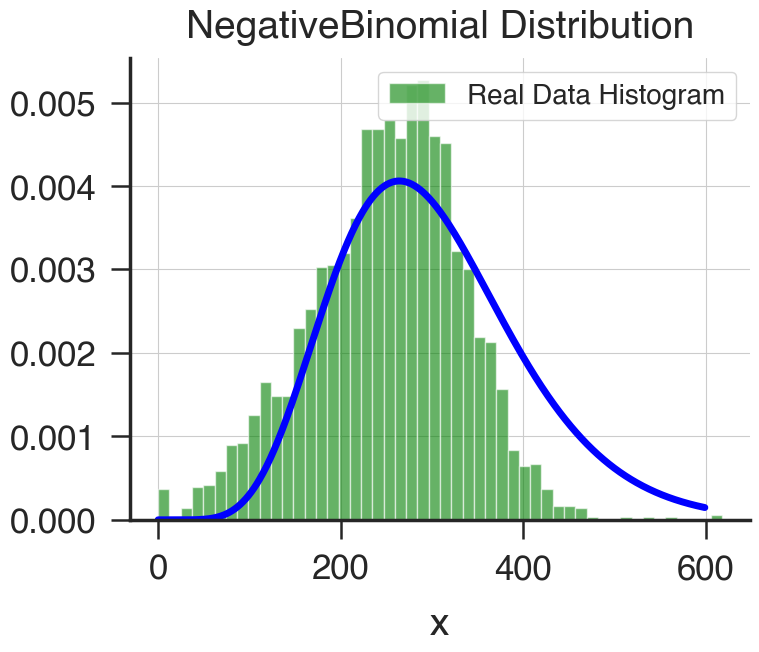

In [393]:
gamma_pre_para = [0.1,0.1]
gamma_para = metropolis_hastings_gamma(gamma_data[gamma_index],gamma_pre_para, n_iter,burn_in ).mean()

x = np.array(range(0,600))
 # pmf = [stats.nbinom.pmf(i, n=col_means[0], p=col_means[1]) for i in x]
#pmf = [stats.gamma.pdf(i, gamma_para[0], scale = 1/gamma_para[1]) for i in x]
pmf = [stats.gamma.pdf(i, 8.4, scale = 1/0.028) for i in x]
# Plot the Gamma distribution
plt.figure(figsize=(8, 6))
plt.plot(x, pmf,  color='b')

plt.hist(gamma_data[gamma_index],  bins=50,density=True, alpha=0.6, color='g', label='Real Data Histogram')

plt.title('NegativeBinomial Distribution')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()

## Model Comparasion

After doing the Baye's Inference on the data based on two different distribution models, we want to compare the goodness of fit for different model type. The method we use here is to calculate the bayes factor. 

In [120]:
def bayes_fac_zinb_nb(theta_zinb,theta_nb,data):
    
    r_nb, p_nb = theta_nb
    mu_zinb, r_zinb , psi= theta_zinb
    mu_nb = r_nb/p_nb - r_nb

    y_0 = data[data == 0]
    y_1 = data[data != 0]
    N_0 = len(y_0)
    N_1 = len(y_1)

    term1 = math.log(psi) *N_1+ nb_acceptance_ratio([mu_nb,r_nb],[mu_zinb,r_zinb],y_1,N_1)
    term2 = N_0 *(np.log(1-psi+psi*pow(r_zinb/(r_zinb+mu_zinb), r_zinb))-r_nb*np.log(r_nb/(r_nb+mu_nb)))
    print(term1,term2)
    return term1+term2
bayes_fac = {}
for i in zinb_index:
    bayes_fac[i]=bayes_fac_zinb_nb(zinb_paras[i],nb_paras[i],data_norm[i])

print(bayes_fac)



-1.4545585040913007 63.87247755295821
-1.648606501667338 43.36947215432522
269.1767416206392 703.8798501440516
593.807758232291 829.9365964229164
326.42110170763226 749.3287545104795
960.2785547124447 853.6045707483231
22.866482728046762 282.42857558684443
516.6748573605319 823.6250153116448
1748.1363018359261 326.45941699489083
1448.0625514854307 730.6811843663063
47.62202546298729 377.46820570578166
{'MT-CO1': 62.41791904886691, 'MT-CYB': 41.720865652657885, 'MT-ND1': 973.0565917646908, 'MT-ND2': 1423.7443546552074, 'MT-ND3': 1075.7498562181117, 'MT-ND4': 1813.8831254607678, 'MT-ND4L': 305.2950583148912, 'MT-ND5': 1340.2998726721767, 'MT-ND6': 2074.595718830817, 'MT-ATP6': 2178.7437358517373, 'MT-ATP8': 425.0902311687689}


In [125]:
nb_paras['MT-CO2','MT']


0    6.464709
1    0.000048
Name: MT-CO2, dtype: float64

In [123]:
zinb_paras

,MT-CO1,MT-CYB,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-ATP6,MT-ATP8
0,79329.375901,83951.149237,31685.895302,19220.621410,22809.604199,14608.657163,51649.091062,20899.709105,7156.192152,10469.159732,75964.806966
1,4.090322,5.363383,3.602833,2.728260,3.332076,2.615771,4.813053,3.065370,2.927348,2.607708,4.633316
2,0.998939,0.999199,0.981357,0.949771,0.975213,0.908243,0.996413,0.961482,0.555612,0.821860,0.995032


In [142]:
fitted_para = pd.concat([zinb_paras[['MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5',
                        'MT-ND6', 'MT-ATP6', 'MT-ATP8']], nb_paras[['MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB']]], axis=1)

fitted_para = fitted_para.loc[:, data_norm.columns.to_list()]
fitted_para

,MT-CO1,MT-CO2,MT-CO3,MT-CYB,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-ATP6,MT-ATP8
0,3.911154,6.464709,6.285661,5.213473,31685.895302,19220.621410,22809.604199,14608.657163,51649.091062,20899.709105,7156.192152,10469.159732,75964.806966
1,0.000049,0.000048,0.000059,0.000062,3.602833,2.728260,3.332076,2.615771,4.813053,3.065370,2.927348,2.607708,4.633316
2,NaN,NaN,NaN,NaN,0.981357,0.949771,0.975213,0.908243,0.996413,0.961482,0.555612,0.821860,0.995032


In [140]:
fitted_para.to_csv('fitted_data/fitted_para.csv', index=False)  